# Paper Plot R2, Profile, Cross-section

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
import os

In [3]:
module_path = os.path.abspath(os.path.join('..'))
# Relative imports
if module_path not in sys.path:
    sys.path.append(module_path)

In [201]:
from utils.setup import SetupDiagnostics
from neural_networks.load_models import load_models, get_save_plot_folder, load_single_model
from neural_networks.model_diagnostics import ModelDiagnostics
from utils.utils import read_ancilaries, find_closest_value, find_closest_longitude  # , get_pressure
from pathlib import Path
from utils.variable import Variable_Lev_Metadata
from neural_networks.cbrain.cam_constants import *
import matplotlib.pyplot as plt
import gc
import pickle
import seaborn as sns
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import cmocean
import seaborn as sns


In [203]:
import matplotlib as mpl
mpl.rcParams.update(mpl.rcParamsDefault)

In [349]:
font_size = 13

In [350]:
plt.rcParams["font.size"] = font_size
plt.rcParams["font.family"] = "serif"
plt.rcParams["font.serif"] = ["Computer Modern"] + plt.rcParams["font.serif"]
plt.rcParams["mathtext.default"] = "regular"


In [351]:
# PROJECT_ROOT = Path.cwd().parent.resolve()
PROJECT_ROOT = Path("/p/scratch/icon-a-ml/kuehbacher1")

# training_92_mask_net_prediction_thresholds_spars1e-4
# training_93_mask_net_prediction_thresholds_spars1e-5

training_run = "training_91_mask_net_prediction_thresholds_spars0.001"
base_dir = os.path.join(PROJECT_ROOT, "output_castle", training_run )
plots_dir = os.path.join(base_dir, "plots_offline_evaluation")
outputs_list_file = os.path.join(base_dir, "outputs_list.txt")

if "prediction_thresholds" in base_dir:
    train_val = "_train"
else: 
    train_val = ""

cfg = os.path.join(base_dir, "cfg_mask_net.yml")

output_dir = os.path.join(base_dir, "plots_offline_evaluation", "plots_paper" + train_val)
Path(output_dir).mkdir(parents=True, exist_ok=True)

ANCIL_FILE = os.path.join(Path.cwd().parent.resolve(), "data", "ancil_spcam.nc")

In [352]:
causal_plot_dir = os.path.join(PROJECT_ROOT, "output_castle", "eval_nando", "causal_single_nn", 
                          "models_arch-rasp_thrs-opt-mse6", "plots_offline_evaluation")


In [407]:
variable = "tphystnd" # tphystnd, phq 
stats = "r2"

In [408]:
profile_dir = os.path.join(plots_dir, "plots_profiles" + train_val, f"range-1440_lats-90_90_lons0.0_359.0_stats-{stats}")
causal_profile_dir = os.path.join(causal_plot_dir, "plots_profiles", f"range-1440_lats-90_90_lons0.0_359.0_stats-{stats}")

In [409]:
def load_pickle(f_name):
    with open(f_name, "rb") as f:
        values = pickle.load(f)
    return values

In [410]:
profiles = dict()

profiles["truth"] = load_pickle(os.path.join(profile_dir, f"{variable}_profile_truth.p"))
profiles["pred"] = load_pickle(os.path.join(profile_dir, f"{variable}_profile_pred.p"))
profiles[stats] = load_pickle(os.path.join(profile_dir, f"{variable}_stats-{stats}.p"))

In [411]:
causal_profiles = dict()

causal_profiles["truth"] = load_pickle(os.path.join(causal_profile_dir, f"{variable}_profile_truth.p"))
causal_profiles["pred"] = load_pickle(os.path.join(causal_profile_dir, f"{variable}_profile_pred.p"))
causal_profiles[stats] = load_pickle(os.path.join(causal_profile_dir, f"{variable}_stats-{stats}.p"))

In [412]:
def parse_txt_to_list(txt_file):
    line_list = list()
    with open(txt_file, 'r') as f:
        for line in f:
            line_list.append(line.rstrip())
    return line_list

In [413]:
outputs_list = parse_txt_to_list(outputs_list_file)

In [414]:
P

array([  3.6434655,   7.5948195,  14.356632 ,  24.61222  ,  38.2683   ,
        54.595478 ,  72.01245  ,  87.82123  , 103.31713  , 121.54725  ,
       142.99405  , 168.22508  , 197.90808  , 232.82861  , 273.91083  ,
       322.24188  , 379.1009   , 445.99258  , 524.6872   , 609.7787   ,
       691.3894   , 763.4045   , 820.85834  , 859.53485  , 887.0203   ,
       912.64453  , 936.1984   , 957.4855   , 976.32544  , 992.5561   ],
      dtype=float32)

In [418]:

def plot_profile_r2(ax1): 
    blue = '#3b4cc0' #"#1E88E5"
    red = '#b40426' #"#D81B60"

    units = {"tphystnd": r"$K/s$", "phq": r"$kg/(kg \cdot s)$"}
    var_label = {"tphystnd": r"$\Delta T_{phy}$", "phq": r"$\Delta q_{phy}$"}

    vmin = np.min([np.min(profiles["pred"]), np.min(profiles["truth"])])
    vmax = np.max([np.max(profiles["pred"]), np.max(profiles["truth"])])
    vlim = np.max([np.abs(vmin), np.abs(vmax)]) / 2.
    vmin = -vlim;
    vmax = vlim
    
    # Plotting on the primary X-axis (bottom)
    line_truth, = ax1.plot(np.mean(profiles["truth"], axis=0), P, label="SPCAM", color=blue)
    line_pred, = ax1.plot(np.mean(profiles["pred"], axis=0), P, label="Prediction PCM", linestyle="dashed", color=blue)
    line_pred_causal, = ax1.plot(np.mean(causal_profiles["pred"], axis=0), P, label="Prediction CI-NN", linestyle="dotted", color=blue)
    
    ax1.set_xlim(vmin, vmax)

    ax1.tick_params(bottom=True, left=True, length=2)
    ax1.tick_params(axis='x', labelsize=font_size)
    ax1.tick_params(axis='y', labelsize=font_size)


    ax1.set_yticks([200, 400, 600, 800])
    
    ax1.set_xlabel(f'{var_label[variable]} ({units[variable]})', color=blue)
    ax1.tick_params(axis='x', colors=blue) 
    
    ax1.set_ylabel('Pressure (hPa)')
  
    
    # Invert the Y-axis
    ax1.invert_yaxis()
    
    # Set the Y-axis labels
    # ax1.set_yticks([1000, 600, 300, 0])
    
    # Create a secondary X-axis (top)
    ax2 = ax1.twiny()  # Share the same Y-axis

    arr = np.mean(profiles[stats], axis=1)
    arr_causal = np.mean(causal_profiles[stats], axis=1)

    if variable == "phq": 
        last_neg_index = np.where(arr< 0)[0][-1]
        # last_neg_index -= 1
    
        print(f"Last negative index: {last_neg_index} ({outputs_list[30 + last_neg_index]})")
        print(f"Start plot from index {last_neg_index + 1} ({outputs_list[30 + last_neg_index +1]})")

        line_r2, = ax2.plot(arr[last_neg_index+1:], P[last_neg_index + 1:], label=r"$R^2$ PCM", color=red)  
        line_r2_causal, = ax2.plot(arr_causal[last_neg_index+1:], P[last_neg_index + 1:], label=r"$R^2$ CI-NN",
                                   linestyle="dotted", color=red)  
    else:     
        line_r2, = ax2.plot(arr, P, label=r"$R^2$ PCM", color=red)  
        line_r2_causal, = ax2.plot(arr_causal, P, label=r"$R^2$ CI-NN",linestyle="dotted", color=red)  
    
    ax2.set_xlim(-0.05, 1.05)
    ax2.set_xlabel(r'$R^2$ Score', color=red)
    ax2.tick_params(axis='x', colors=red)  # Set color of ticks and labels to red
    
    ax2.spines['top'].set_color(red)  
    ax2.spines['bottom'].set_color(blue)
    
    # ax1.set_ylabel('Pressure (hPa)', labelpad=15, color='#333333')
    # ax1.set_xlabel(f"{s}", labelpad=15, color='#333333')
    ax1.set_rasterized(True)
    ax2.set_rasterized(True)
    
    plt.legend(handles=[line_truth, line_pred, line_pred_causal, line_r2, line_r2_causal], 
               prop={'size': 12}, loc="center left")



Saved figure /p/scratch/icon-a-ml/kuehbacher1/output_castle/training_91_mask_net_prediction_thresholds_spars0.001/plots_offline_evaluation/plots_paper_train/tphystnd_profile_r2.pdf


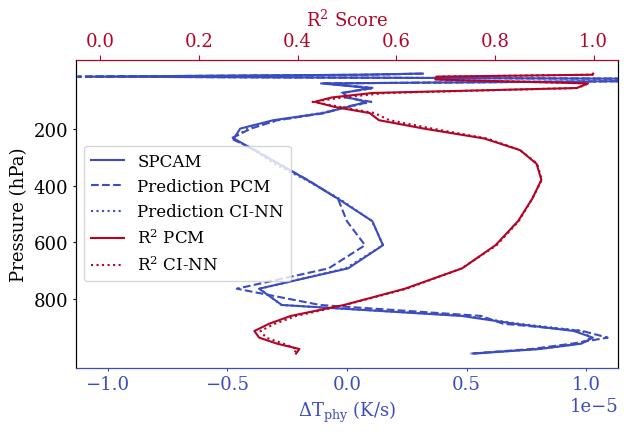

In [419]:
plt.close()

fig, ax1 = plt.subplots(figsize=(7, 4))
plot_profile_r2(ax1)

# f_path = os.path.join(output_dir, f"{variable}_profile_r2_cutoff_168.pdf")
f_path = os.path.join(output_dir, f"{variable}_profile_r2.pdf")
fig.savefig(f_path, format="pdf", bbox_inches="tight", transparent=True)
print(f"Saved figure {f_path}")

plt.show()

In [396]:
cross_section_dir = os.path.join(plots_dir, "plots_cross_section" + train_val, f"mean-all_stats-{stats}_no_diff")

In [397]:
cross_sections = dict()

cross_sections["truth"] = load_pickle(os.path.join(cross_section_dir, f"{variable}_cross_section_truth.p"))
cross_sections["pred"] = load_pickle(os.path.join(cross_section_dir, f"{variable}_cross_section_pred.p"))
cross_sections[stats] = load_pickle(os.path.join(cross_section_dir, f"{variable}_cross_section_stats-{stats}.p"))

In [398]:
v_name = variable

In [399]:

def plot_cross_section(ax, truth_or_pred, v_name, set_title=True):
    
    vmin = np.min([np.min(cross_sections["pred"]), np.min(cross_sections["truth"])])
    vmax = np.max([np.max(cross_sections["pred"]), np.max(cross_sections["truth"])])
    
    vlim = np.max([np.abs(vmin), np.abs(vmax)]) / 2.
    vmin = -vlim;
    vmax = vlim
    
    extend = None
    
    cThemes = {'tphystnd': 'RdBu', 'phq': 'RdBu'}
    cmap = cThemes[v_name]

    levels, latitudes, longitudes = read_ancilaries(Path(ANCIL_FILE))

    
    # I = ax.imshow(cross_sections[truth_or_pred], vmin=vmin, vmax=vmax, cmap=cmap, interpolation="gaussian")
    I = ax.pcolormesh(latitudes, P, cross_sections[truth_or_pred], vmin=vmin, vmax=vmax, cmap=cmap)
    ax.invert_yaxis()

    ax.tick_params(bottom=True, left=True, length=2)
    ax.tick_params(axis='x', labelsize=font_size)
    ax.tick_params(axis='y', labelsize=font_size)

    # lat_ticks = [int(l) for l in range(len(latitudes)) if l % 9 == 0]
    # lat_labels = [str(int(l)) for i, l in enumerate(latitudes) if i % 9 == 0]
    ax.set_xticks([-90, -60, -30, 0, 30, 60, 90])
    ax.set_xticklabels([r"$-90^{\circ}$S",  r"$-60^{\circ}$S", r"$-30^{\circ}$S", r"EQ.", 
                        r"$30^{\circ}$N", r"$60^{\circ}$N", r"$90^{\circ}$N"])
    ax.set_xlabel('Latitude')

    # pressure_ticks = [int(press) for press in range(len(P)) if press % 5 == 0]
    # pressure_label = [str(int(press)) for i, press in enumerate(P) if i % 5 == 0]
    # ax.set_yticks(pressure_ticks)
    # ax.set_yticklabels(pressure_label)
    ax.set_yticks([200, 400, 600, 800])
    ax.set_ylabel('Pressure (hPa)')

    # cb = fig.colorbar(I, ax=ax, orientation='horizontal', extend=extend)
    # cb.set_label('')
    #  (left, bottom, width, height)
    cax = fig.add_axes([ax.get_position().x0, ax.get_position().y0 - 0.16,
                        ax.get_position().width,  0.03])
    cb = fig.colorbar(I, cax=cax, orientation='horizontal', extend=extend)
    cb.set_label('')
    

    if set_title:
        if truth_or_pred == "truth":
            ax.set_title("SPCAM Truth", fontsize=font_size)
        else: 
            ax.set_title("PCMasking Prediction", fontsize=font_size)

    ax.set_rasterized(True)
    





Saved figure /p/scratch/icon-a-ml/kuehbacher1/output_castle/training_91_mask_net_prediction_thresholds_spars0.001/plots_offline_evaluation/plots_paper_train/phq_cross_section_pred.pdf


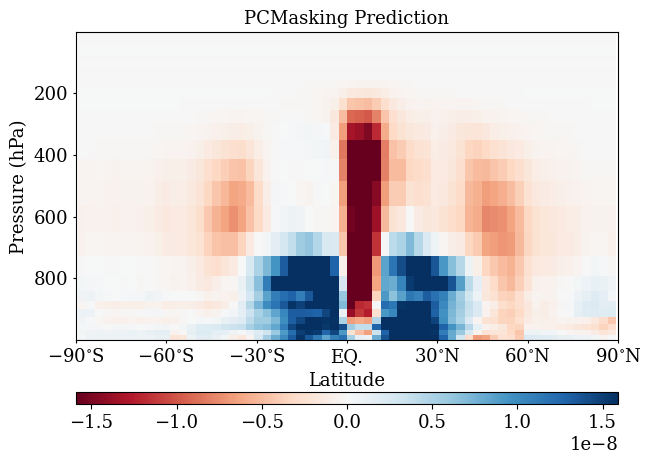

In [400]:
# Create a figure and an axis
plt.close()
fig, ax = plt.subplots(figsize=(7, 4))

plot_cross_section(ax, "pred", variable)

f_path = os.path.join(output_dir, f"{variable}_cross_section_pred.pdf")
fig.savefig(f_path, format="pdf", bbox_inches="tight", transparent=True)
print(f"Saved figure {f_path}")

plt.show()

Saved figure /p/scratch/icon-a-ml/kuehbacher1/output_castle/training_91_mask_net_prediction_thresholds_spars0.001/plots_offline_evaluation/plots_paper_train/phq_cross_section_truth.pdf


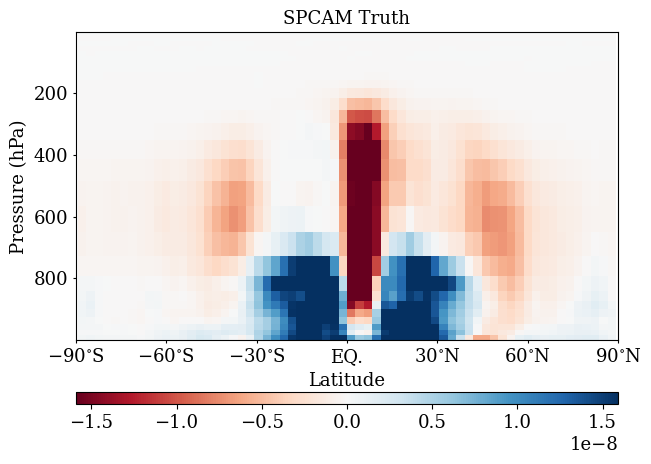

In [401]:
# Create a figure and an axis
plt.close()
fig, ax = plt.subplots(figsize=(7, 4))

plot_cross_section(ax, "truth", variable)

f_path = os.path.join(output_dir, f"{variable}_cross_section_truth.pdf")
fig.savefig(f_path, format="pdf", bbox_inches="tight", transparent=True)
print(f"Saved figure {f_path}")

plt.show()

In [402]:
import copy

In [403]:

def plot_cross_section_r2(ax, set_title=True):
    vmin = 0.;
    vmax = 1.
    extend = 'min'
    cmap = 'Reds'

    stats_plot = copy.deepcopy(cross_sections[stats])

    if variable == "phq": 
        last_neg_index = 10
        # last_neg_index -= 1
    
        print(f"Last negative index: {last_neg_index} ({outputs_list[30 + last_neg_index]})")

        stats_plot[0:last_neg_index + 1, :,] = -np.inf

        
    # I = ax.imshow(cross_sections[stats][:-last_neg_index, :], vmin=vmin, vmax=vmax, cmap=cmap)
    # I = ax.imshow(stats_plot, vmin=vmin, vmax=vmax, cmap=cmap)
    
    # cb = fig.colorbar(I, ax=ax, orientation='horizontal', extend=extend)
    # cb.set_label('')
    
    # levels, latitudes, longitudes = read_ancilaries(Path(ANCIL_FILE))
    # pressure_ticks = [int(press) for press in range(len(P)) if press % 5 == 0]
    # pressure_label = [str(int(press)) for i, press in enumerate(P) if i % 5 == 0]
    # ax.set_yticks(pressure_ticks)
    # ax.set_yticklabels(pressure_label)
    # ax.set_ylabel('Pressure (hPa)')
    
    # lat_ticks = [int(l) for l in range(len(latitudes)) if l % 9 == 0]
    # lat_labels = [str(int(l)) for i, l in enumerate(latitudes) if i % 9 == 0]
    # ax.set_xticks(lat_ticks)
    # ax.set_xticklabels(lat_labels)
    # ax.set_xlabel('Latitude')
    
    # ax.set_rasterized(True)

    levels, latitudes, longitudes = read_ancilaries(Path(ANCIL_FILE))

    
    I = ax.pcolormesh(latitudes, P, stats_plot, vmin=vmin, vmax=vmax, cmap=cmap)
    ax.invert_yaxis()

    ax.tick_params(bottom=True, left=True, length=2)
    ax.tick_params(axis='x', labelsize=font_size)
    ax.tick_params(axis='y', labelsize=font_size)

    # lat_ticks = [int(l) for l in range(len(latitudes)) if l % 9 == 0]
    # lat_labels = [str(int(l)) for i, l in enumerate(latitudes) if i % 9 == 0]
    ax.set_xticks([-90, -60, -30, 0, 30, 60, 90])
    ax.set_xticklabels([r"$-90^{\circ}$S",  r"$-60^{\circ}$S", r"$-30^{\circ}$S", r"EQ.", 
                        r"$30^{\circ}$N", r"$60^{\circ}$N", r"$90^{\circ}$N"])
    ax.set_xlabel('Latitude')

    # pressure_ticks = [int(press) for press in range(len(P)) if press % 5 == 0]
    # pressure_label = [str(int(press)) for i, press in enumerate(P) if i % 5 == 0]
    # ax.set_yticks(pressure_ticks)
    # ax.set_yticklabels(pressure_label)
    ax.set_yticks([200, 400, 600, 800])
    ax.set_ylabel('Pressure (hPa)')

    # cb = fig.colorbar(I, ax=ax, orientation='horizontal', extend=extend)
    # cb.set_label('')
    #  (left, bottom, width, height)
    cax = fig.add_axes([ax.get_position().x0, ax.get_position().y0 - 0.16,
                        ax.get_position().width,  0.03])
    cb = fig.colorbar(I, cax=cax, orientation='horizontal', extend=extend)
    cb.set_label('')
    

    if set_title:
        ax.set_title(r"$R^{2}$ Score", fontsize=font_size)

    ax.set_rasterized(True)
   

Last negative index: 10 (phq-142.99)
Saved figure /p/scratch/icon-a-ml/kuehbacher1/output_castle/training_91_mask_net_prediction_thresholds_spars0.001/plots_offline_evaluation/plots_paper_train/phq_cross_section_r2_cutoff_168.pdf


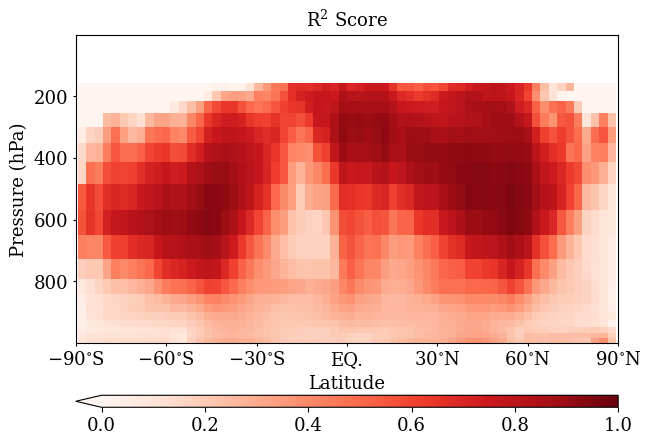

In [404]:
plt.close()
fig, ax = plt.subplots(figsize=(7, 4))
plot_cross_section_r2(ax)

f_path = os.path.join(output_dir, f"{variable}_cross_section_r2_cutoff_168.pdf")
# f_path = os.path.join(output_dir, f"{variable}_cross_section_r2.pdf")
fig.savefig(f_path, format="pdf", bbox_inches="tight", transparent=True)
print(f"Saved figure {f_path}")

 
plt.show()

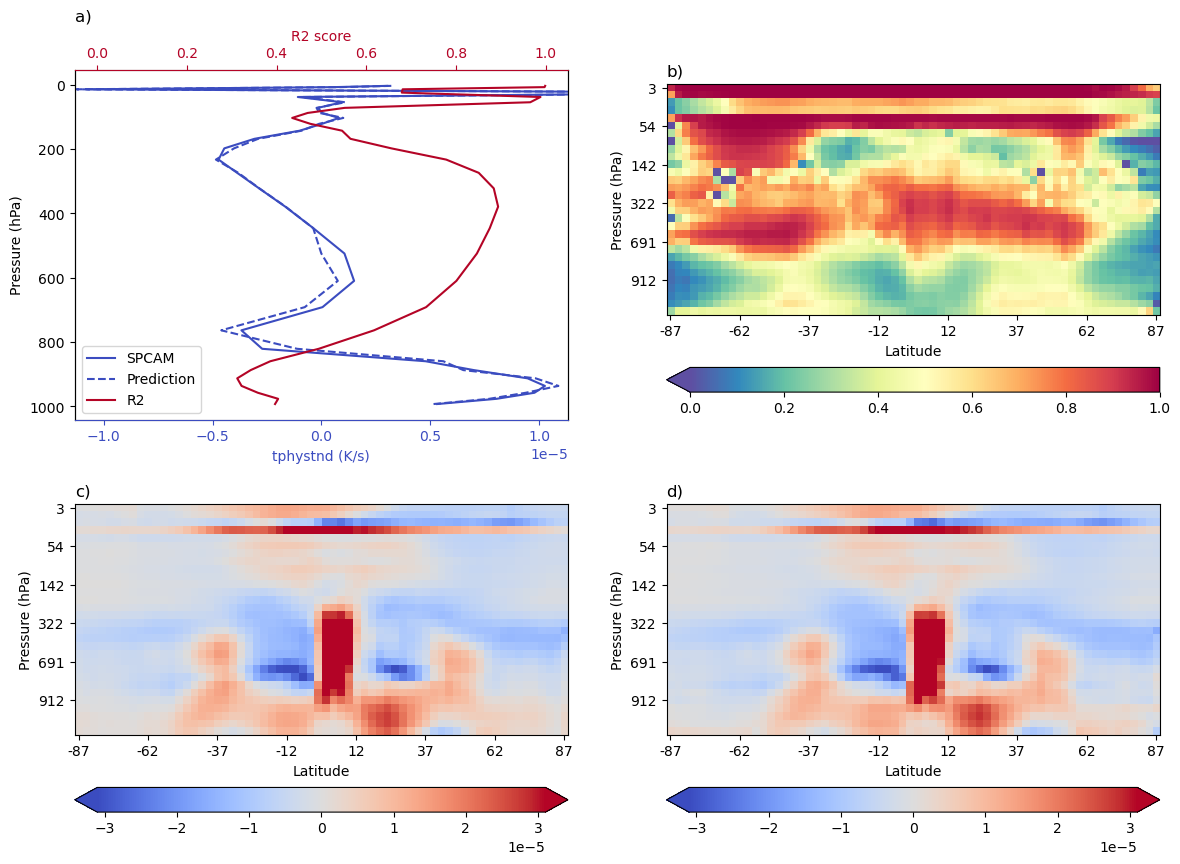

In [20]:
plt.close()

fig, axs = plt.subplots(2, 2,  figsize=(14, 10))
# fig, axs = plt.subplot_mosaic([['a)', 'b)'], ['c)', 'd)']],
#                               layout='constrained', 
#                               figsize=(14, 10))

plot_profile_r2(axs[0, 0])
axs[0, 0].set_title("a)", fontsize="large", loc="left")

plot_cross_section_r2(axs[0, 1])
axs[0, 1].set_title("b)", fontsize="large", loc="left")

plot_cross_section(axs[1, 0], "truth", variable)
axs[1, 0].set_title("c)", fontsize="large", loc="left")

plot_cross_section(axs[1, 1], "pred", variable)
axs[1, 1].set_title("d)", fontsize="large", loc="left")


plt.show()
